[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kjmazidi/Machine_Learning_3rd_edition/blob/master/Volume_II_Python/Part-2-ML_sklearn/4-01-DT-classification.ipynb)

# Quick sklearn examples
## Airquality data

This notebook provides a simple example of regression, classification and clustering with sklearn using the airquality data set from R available here: https://vincentarelbundock.github.io/Rdatasets/datasets.html

### Code Accompanying ***The Machine Learning Handbooks***, Volume II, Chapter 4

#### Book pdf is available on the GitHub repo: <https://github.com/kjmazidi/Machine_Learning_3rd_edition>

###### (c) 2025 KJG Mazidi, all rights reserved

In [32]:
# imports used in this notebook

import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

### Data Exploration

First we load the data and take a look. This data was collected from New York City in the 1970s. It is a small data set but will work for illustration purposes. The data provides metrics for Ozone, Solar, Wind, and Temperature across summer dates in 1973. 

In [2]:
### load the data using pandas

df = pd.read_csv('data/airquality.csv')
print(df.head())
print('\nDimensions of data frame:', df.shape)

   rownames  Ozone  Solar.R  Wind  Temp  Month  Day
0         1   41.0    190.0   7.4    67      5    1
1         2   36.0    118.0   8.0    72      5    2
2         3   12.0    149.0  12.6    74      5    3
3         4   18.0    313.0  11.5    62      5    4
4         5    NaN      NaN  14.3    56      5    5

Dimensions of data frame: (153, 7)


### Let's explore how many missing values there are 

There don't seem to be too many NAs, so we will simply remove rows with missing values

In [3]:
df.isnull().sum()

rownames     0
Ozone       37
Solar.R      7
Wind         0
Temp         0
Month        0
Day          0
dtype: int64

In [4]:
# omit rows with missing values

df = df.dropna()
df.shape

(111, 7)

In [5]:
# examine statistics for main columns of interest

df[['Ozone', 'Solar.R', 'Wind', 'Temp']].describe()

,Ozone,Solar.R,Wind,Temp
count,111.000000,111.000000,111.000000,111.000000
mean,42.099099,184.801802,9.939640,77.792793
std,33.275969,91.152302,3.557713,9.529969
min,1.000000,7.000000,2.300000,57.000000
25%,18.000000,113.500000,7.400000,71.000000
50%,31.000000,207.000000,9.700000,79.000000
75%,62.000000,255.500000,11.500000,84.500000
max,168.000000,334.000000,20.700000,97.000000


Looking at the data, most of it is numeric which is fine. The rownames column is not important for our purposes. The Month and Day could be used for time series exploration, which is beyond the scope of this book. 

In order to have a categorical column, we will add a new column, Ozone_High which will be 1 for Ozone levels above average and 0 otherwise. We could have used np.median() since we have removed NAs but here we demonstrate how to find the median in an array that may have NAs with np.nanmedian()

In [37]:
# use nanmedian() instead of median() to ignore missing values
med_Ozone = np.nanmedian(df['Ozone'])

# make a zero-filled array
z = np.zeros(len(df.Ozone))

# vectorized numpy operation
z[df.Ozone>med_Ozone] = 1

# add the array to the dataframe then convert it to categorical
df['Ozone_High'] = z
df['Ozone_High'] = df['Ozone_High'].astype('category').cat.codes

df.head()

,rownames,Ozone,Solar.R,Wind,Temp,Month,Day,Ozone_High
0,1,41.0,190.0,7.4,67,5,1,1
1,2,36.0,118.0,8.0,72,5,2,1
2,3,12.0,149.0,12.6,74,5,3,0
3,4,18.0,313.0,11.5,62,5,4,0
6,7,23.0,299.0,8.6,65,5,7,0


### Explore the data graphically

Looking at distributions of the data give us insights that will be helpful in machine learning

The first graph shows that the data is fairly evenly distributed between high and low Ozone days, which is not surprising since we made a split at the median value of Ozone. 

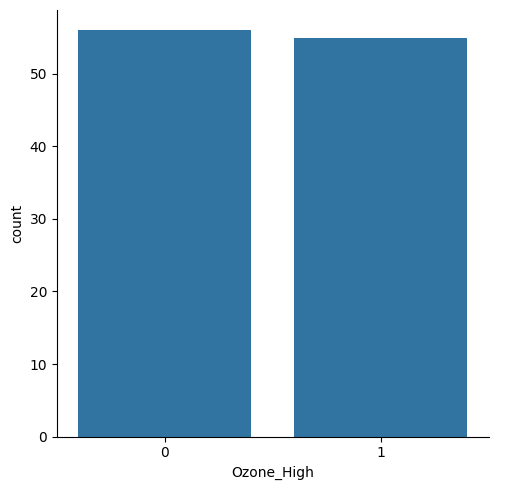

In [7]:
sb.catplot(x='Ozone_High', kind='count', data=df)

The next graph looks at the distribution of low ozone days versus high. Low oxone days are grouped together but the high ozone days have a wider distribution. 

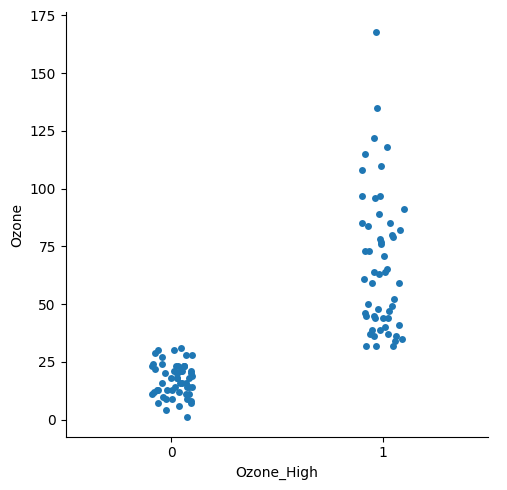

In [8]:
sb.catplot(x='Ozone_High', y='Ozone', data=df)

Next we see a positive correlation between temperature and ozone. That is, higher temperature days tend to have higher ozone levels. 

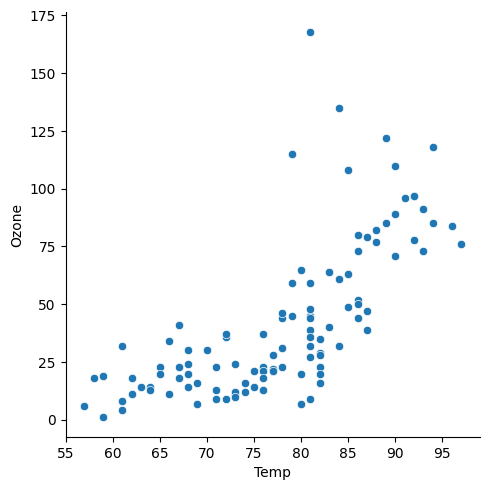

In [9]:
sb.relplot(x='Temp', y='Ozone', data=df)

#the following two lines show how to save the a plot
#fig = sb.relplot(x='Temp', y='Ozone', data=df)
#fig.savefig("out.png") 

Next we see a negative correlation between wind and ozone. That is, days with low wind tend to have higher ozone while windy days must blow it away. 

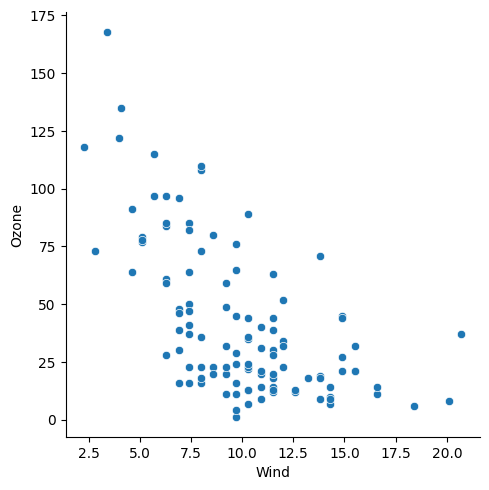

In [10]:
sb.relplot(x='Wind', y='Ozone', data=df)

The following graph shows that higher solar days tend to have higher ozone, but the correlation appears weaker than wind or temperature. 

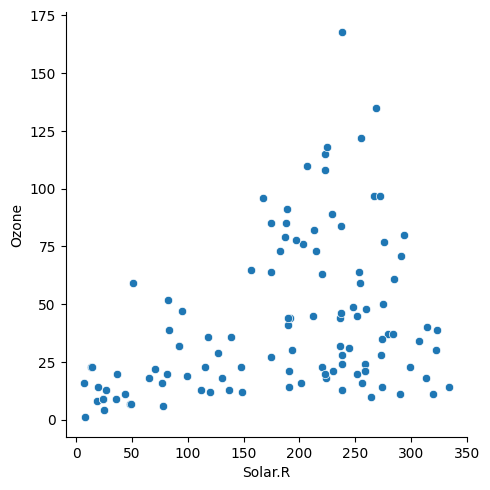

In [11]:
sb.relplot(x='Solar.R', y='Ozone', data=df)

### Quantify correlations observed in the graphs

Next we print out a correlation matrix and observe that:

* Temp has a high positive correlation with ozone of 0.77
* Wind has a moderate negative correlation with ozone of -.6
* Solar.R has a weak positive correlation with ozone of 0.3

We see that perhaps Temp and Wind will be fairly good predictors of Ozone, with Solar.R making a weaker contribution to the model. 

In [12]:
# correlations

df[['Ozone', 'Solar.R', 'Wind', 'Temp']].corr(method='spearman')


,Ozone,Solar.R,Wind,Temp
Ozone,1.000000,0.348186,-0.605136,0.772932
Solar.R,0.348186,1.000000,-0.061696,0.209537
Wind,-0.605136,-0.061696,1.000000,-0.499323
Temp,0.772932,0.209537,-0.499323,1.000000


### Train, Test Split

For regression or classification, we need to split the data into a training set of 80% and test set of 20%. For clustering we will use all the data. 

First we make a train/test split for regression using Ozone as the target. 

In [13]:
# train test split using sklearn

X = df.loc[:, ['Solar.R', 'Wind', 'Temp']]
y = df.Ozone

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print('train size:', X_train.shape)
print('test size:', X_test.shape)

train size: (88, 3)
test size: (23, 3)


## Regression

In a regression task, we are building a model of the 3 predictor columns of solar, wind, and temp and the target ozone. We will use y_reg as the target since regression shoule have a numeric target. We are demonstrating regression with linear regression which will be explore further in a subsequent chapter. 

### First we train the model

In the code below, the variable *linreg* will hold the model and all that it learned. First, the variable *linreg* is first instantiated to a LinearRegression object, then fit to the training data. 

In [2]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.score(X_train, y_train)

NameError: name 'LinearRegression' is not defined

NameError: name 'linreg' is not defined

### Predict

Next we make predictions of Ozone on the test data that the model has not seen before. We output the first 10 predictions just to check if the predictions seem reasonable. 

In [16]:
y_pred_reg = linreg.predict(X_test)
y_pred_reg[:10]

array([54.8370501 , 41.16595095, 86.97146365, 66.99693208, 60.65380831,
       66.27244719, 78.25614291, 35.70309404, 21.22719951, 34.02857704])

### Evaluate

How well did the model predict ozone levels from the test data?

In [17]:
print('mse=', mean_squared_error(y_test, y_pred_reg))
print('correlation=', r2_score(y_test, y_pred_reg))

mse= 509.86789511028513
correlation= 0.6521526796389199


These results are pretty bad. Let's plot the actual y values along with the predicted values. 

We can see that the line of regression captures the general trend, but there are many points in the test data that are far above or below the line. One possiblity is that these are outliers. However, we should also consider the possibility that the data is more complex than a linear model can capture and we should use another algorithm on this data, such as kNN. These considerations will inform our discussions throughout the book. 

<Axes: xlabel='Ozone'>

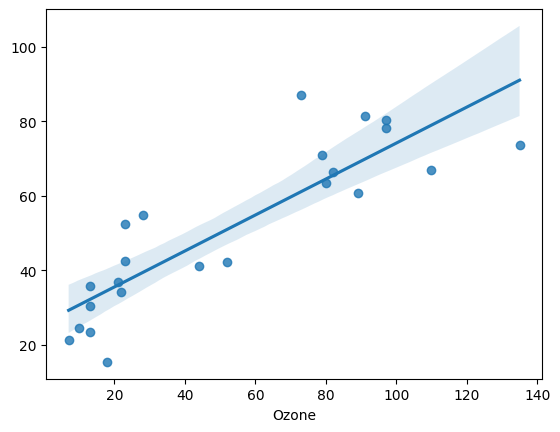

In [18]:
# plot correlation

sb.regplot(x=y_test, y=y_pred_reg)

# to save the plot
#fig = sb.relplot(x=y_test, y=y_pred_reg)
#fig.savefig("out2.png") 

## Classification

In a classification task, we are building a model of the 3 predictor columns of solar, wind, and temp and the target Ozone_high. 

### Split data and train the model

We split the data again because we want a different y target. 

In the code below, the variable *clf* will hold the model and all that it learned. First, the variable *clf* is first instantiated to a LinearRegression object, then fit to the training data. 

In [26]:
# train test split using sklearn

X = df.loc[:, ['Solar.R', 'Wind', 'Temp']]
y = df.Ozone_High

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print('train size:', X_train.shape)
print('test size:', X_test.shape)

train size: (88, 3)
test size: (23, 3)


In [27]:
# instantiate sklearn classifier and fit the data

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [28]:
# make predictions

pred = clf.predict(X_test)

In [29]:
# evaluate using sklearn metrics

print('accuracy score: ', accuracy_score(y_test, pred))
print('precision score: ', precision_score(y_test, pred))
print('recall score: ', recall_score(y_test, pred))
print('f1 score: ', f1_score(y_test, pred))

accuracy score:  0.8695652173913043
precision score:  0.8
recall score:  1.0
f1 score:  0.888888888888889


In [30]:
# output sklearn confusion matrix

confusion_matrix(y_test, pred)

array([[ 8,  3],
       [ 0, 12]])

In [31]:
# output sklearn classification report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.80      1.00      0.89        12

    accuracy                           0.87        23
   macro avg       0.90      0.86      0.87        23
weighted avg       0.90      0.87      0.87        23



## Clustering

The code below demonstrates the kmeans algorithm, discussed further in an upcoming chapter. 

In [55]:
df_subset = df[['Ozone', 'Temp', 'Wind']]

In [56]:
model=KMeans(n_clusters=2)
model.fit(df_subset)

/Users/janicemazidi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2)

In [62]:
model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)

The model labels 0, 1 are arbitrary, whereas our Ozone_High labels have a meaning. In this case we are going to change the labels to make our graphs below more interpretable. 

In [ ]:
# swap the values if needed for clarity of the graphs below
#results = np.zeros(len(df))
#results[model.labels_ == 0] = 1
#results

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

<Axes: xlabel='Temp', ylabel='Ozone'>

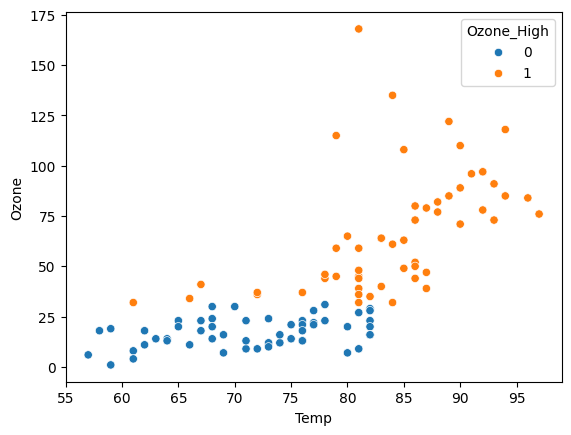

In [63]:
# plot actual labels using seaborn

sb.scatterplot(x='Temp', y='Ozone', hue='Ozone_High', data=df)

<Axes: xlabel='Temp', ylabel='Ozone'>

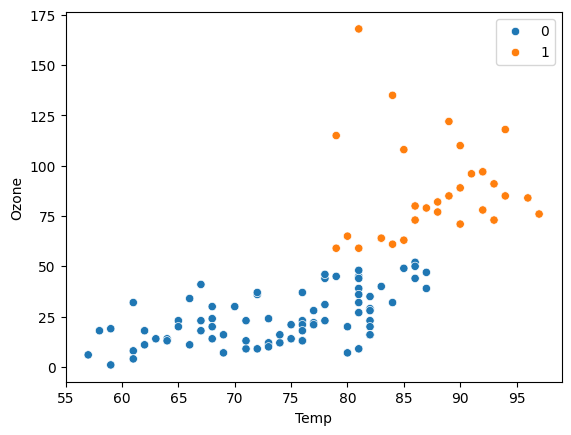

In [64]:
# plot cluster results using seaborn

sb.scatterplot(x='Temp', y='Ozone', hue=model.labels_, data=df)
#sb.scatterplot(x='Temp', y='Ozone', hue=results, data=df)

In [65]:
model.cluster_centers_

array([[24.3625    , 73.925     , 11.1675    ],
       [87.87096774, 87.77419355,  6.77096774]])